Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [80]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [81]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [82]:
os.getcwd()

'/content'

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [83]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [84]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [85]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [86]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [87]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [88]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

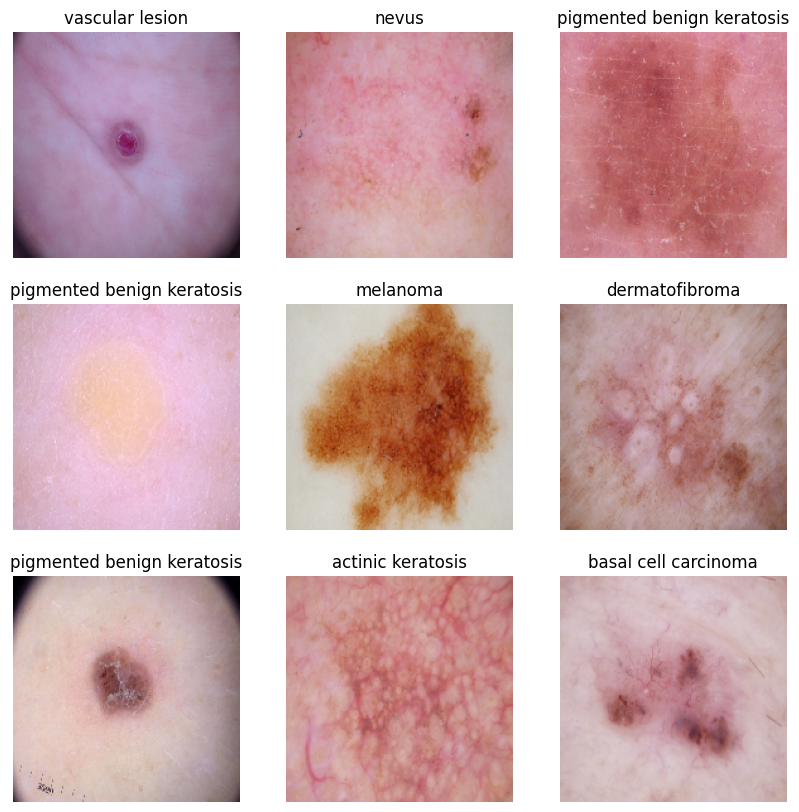

In [89]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [90]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [91]:
### Your code goes here
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.21536125 0.9150336


In [92]:
# getting the number of classes in the dataset
num_classes = len(class_names)

# building the model with keras Sequential with relu as activation function
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [93]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [94]:
# View the summary of all layers
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 64)       

### Train the model

In [95]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 78s 1s/step - loss: 1.8970 - accuracy: 0.2913 - val_loss: 1.6683 - val_accuracy: 0.3848
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.6240 - accuracy: 0.4135 - val_loss: 1.5571 - val_accuracy: 0.4698
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4506 - accuracy: 0.4933 - val_loss: 1.4948 - val_accuracy: 0.5056
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3124 - accuracy: 0.5363 - val_loss: 1.4360 - val_accuracy: 0.5145
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.1967 - accuracy: 0.5815 - val_loss: 1.3789 - val_accuracy: 0.5347
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.1120 - accuracy: 0.6060 - val_loss: 1.4580 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 1.0392 - accuracy: 0.6205 - val_loss: 1.3369 - val_accuracy: 0.5414
Epoch 8/20
56/

### Visualizing training results

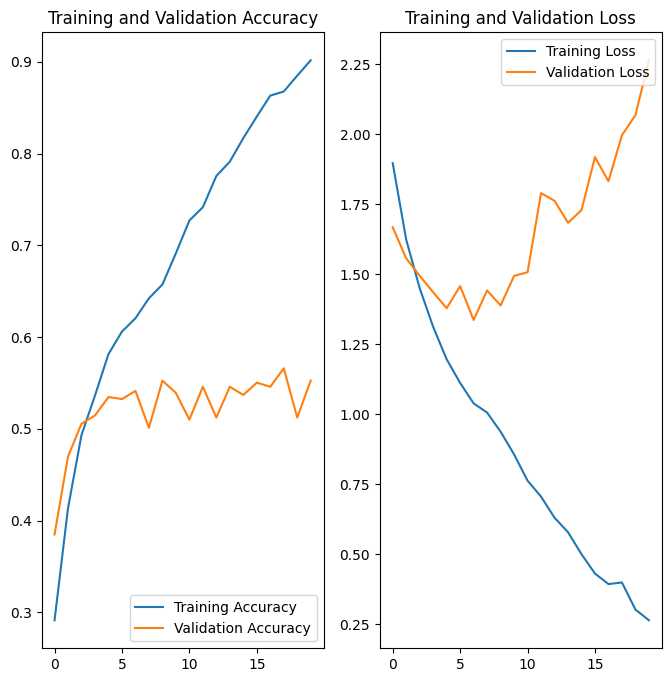

In [96]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Findings


*   Validation accuracy is slightly higher in the initial stage and it hovers arround 0.55 level 
*   Validation Loss is very high compare to training loss towards right-side of the plot
*   Validation loss is slightly low compare to training loss in the left-side/initial stage

Based on above findings, we can say that the model is overfitting

### Write your findings here

In [97]:
# As the model is overfitting, lets due the agumentation to reduce the overfitting
# Let's use random flip, rotate and zoom for agumentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)])

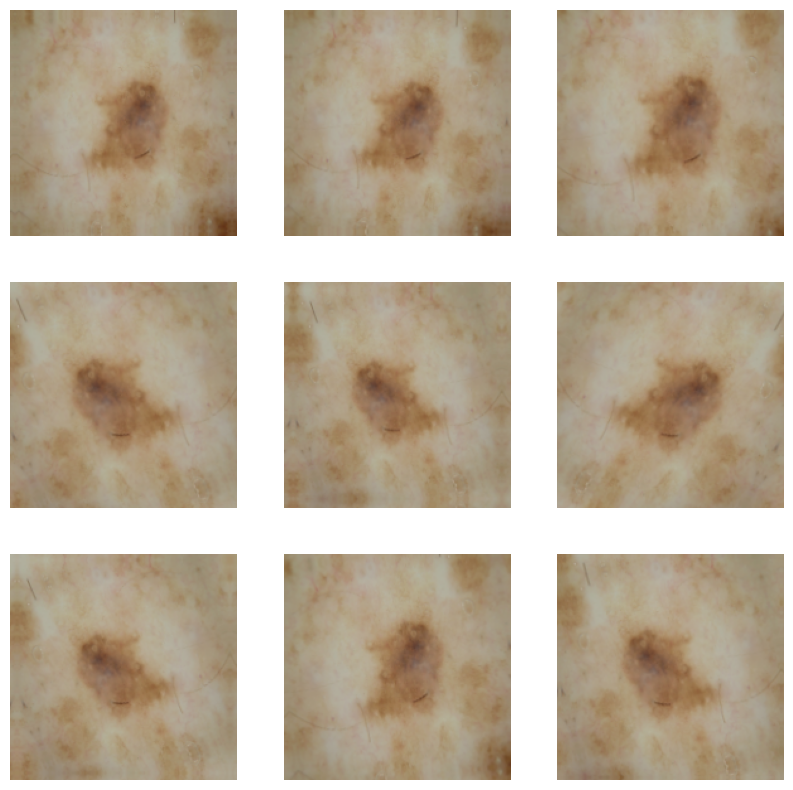

In [98]:
#visualize how your augmentation strategy works for one instance of training image.
# setting the output image size
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model


In [99]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
# Let's add some dropout layers to the model as our model is overfitting
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [100]:
## Your code goes here

In [101]:
## compiling the model with adam optinizer and crossentropy for loss function and accuracy as metrics
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# printing the model summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

### Training the model

In [102]:
## Your code goes here, note: train your model for 20 epochs
# We are not changing the epochs count for the second model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 38ms/step - loss: 2.1330 - accuracy: 0.1936 - val_loss: 2.0135 - val_accuracy: 0.2103
Epoch 2/20
56/56 [==============================] - 2s 31ms/step - loss: 1.9732 - accuracy: 0.2539 - val_loss: 2.1132 - val_accuracy: 0.2461
Epoch 3/20
56/56 [==============================] - 2s 31ms/step - loss: 1.7524 - accuracy: 0.3627 - val_loss: 1.6395 - val_accuracy: 0.4340
Epoch 4/20
56/56 [==============================] - 2s 31ms/step - loss: 1.5471 - accuracy: 0.4570 - val_loss: 1.5226 - val_accuracy: 0.4855
Epoch 5/20
56/56 [==============================] - 2s 31ms/step - loss: 1.4668 - accuracy: 0.4883 - val_loss: 1.4327 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 2s 30ms/step - loss: 1.3756 - accuracy: 0.5218 - val_loss: 1.4673 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 2s 32ms/step - loss: 1.4303 - accuracy: 0.4777 - val_loss: 1.4311 - val_accuracy: 0.5235
Epoch 8/20
56

### Visualizing the results

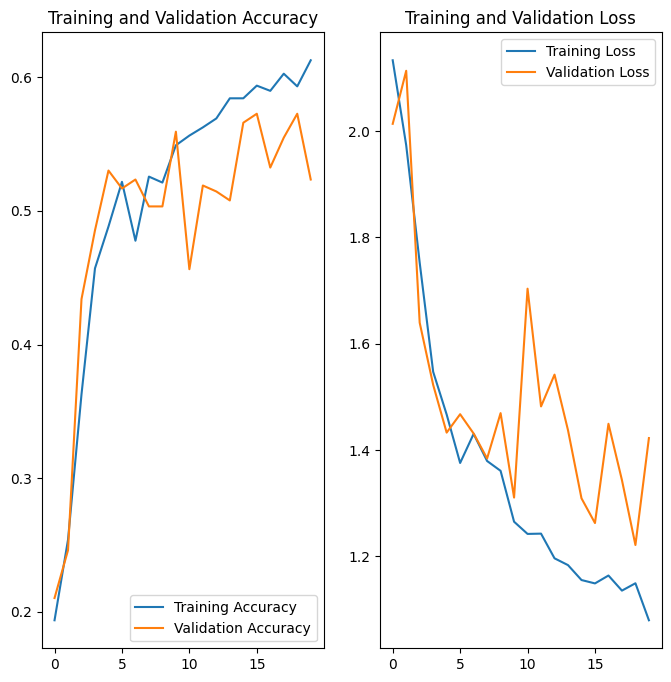

In [103]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Findings


*   Training and validation accuracy are following the same trend, but there are some spike up & down in validation accuracy

*  We can observe the same behavior in the Validation and Training loss, where Validation loss is following the same tread as training loss and there are spikes in the loss
*   there is some distortion in the validation results compare to training results, this might be caused by class imbalance



#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [104]:
## Your code goes here.
## original_df - > path_list, lesion_list
path_list=[]
lesion_list=[]

In [105]:
for i in class_names:
  for j in data_dir_train.glob(i+'/*.jpg'):
    path_list.append(str(j))
    lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
1,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
2,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
3,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
4,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,vascular lesion
2235,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,vascular lesion
2236,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,vascular lesion
2237,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,vascular lesion


<BarContainer object of 9 artists>

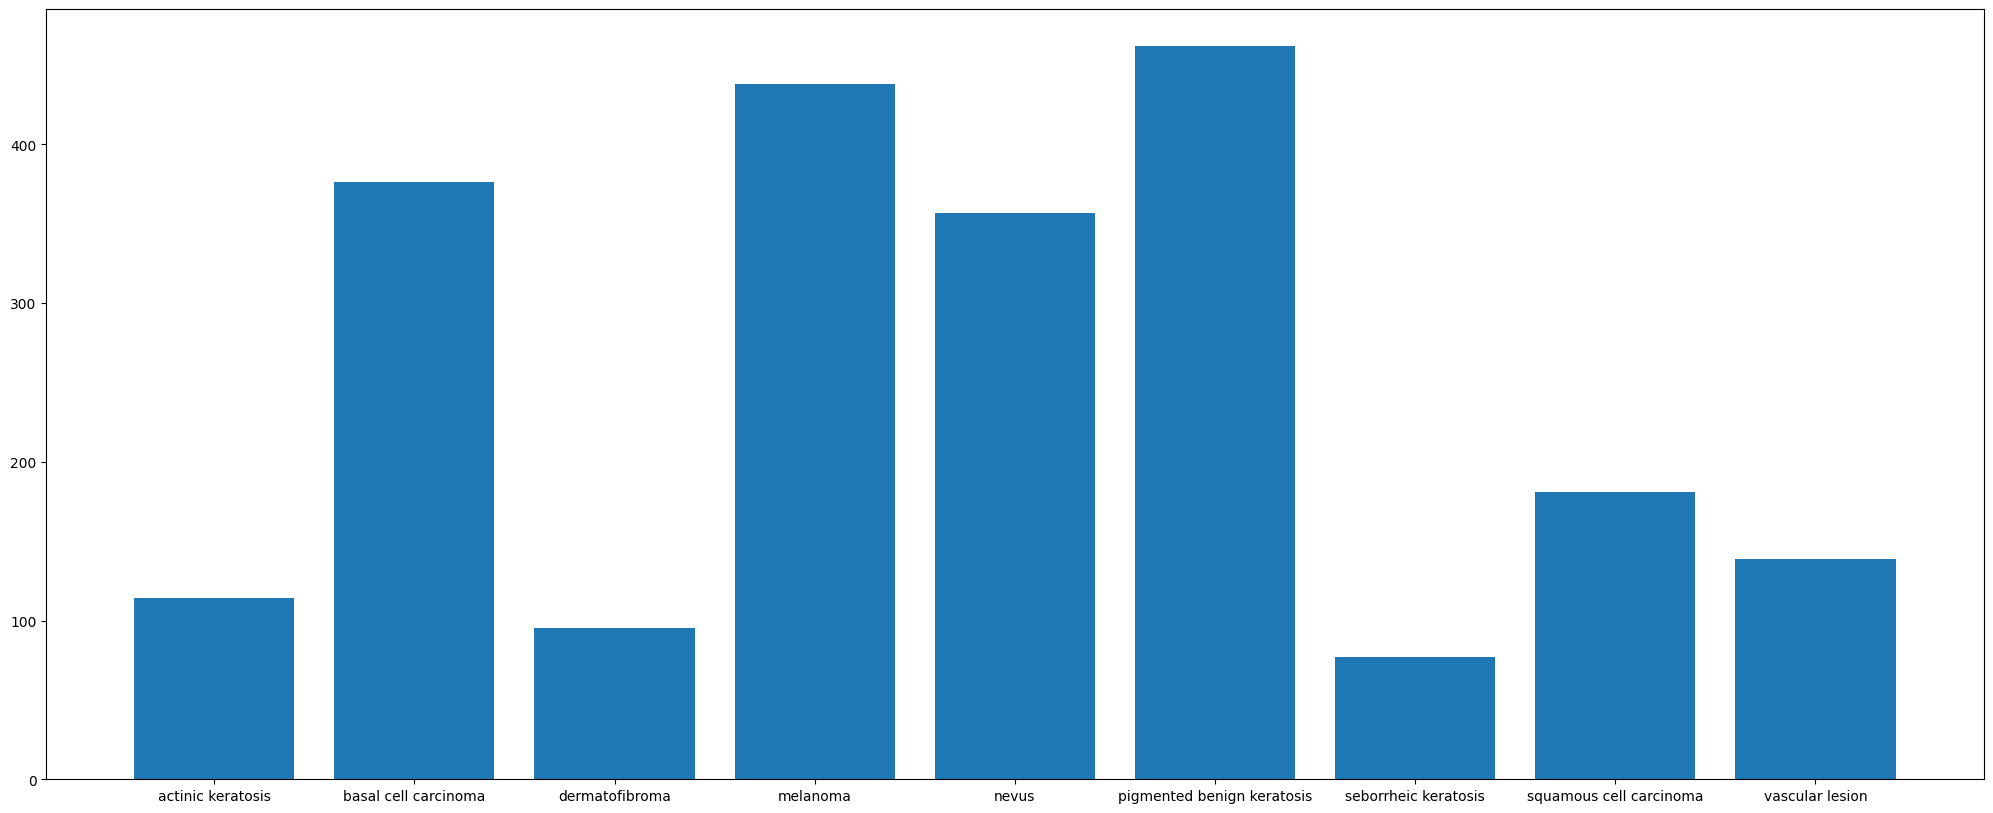

In [106]:
# glob('./Skin cancer ISIC The International Skin Imaging Collaboration/train/*/*')
# './Skin cancer ISIC The International Skin Imaging Collaboration/train\\actinic keratosis\\ISIC_0025780.jpg'
class_count=[]
for i in class_names:
    class_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,class_count)

####  findings here: 
#### - seborrheic keratosis has the least number of samples
#### - below classes dominate the data in terms proportionate number of samples
* pigmented benign
* melanoma
* basal cell carcinoma
* nevus


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [107]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [108]:
path_to_training_dataset= "/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0B9FE7D6A0>: 100%|██████████| 500/500 [00:27<00:00, 18.46 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0A694DFF10>: 100%|██████████| 500/500 [00:29<00:00, 16.80 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0B9F919A30>: 100%|██████████| 500/500 [00:22<00:00, 22.40 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F0B9F91F880>: 100%|██████████| 500/500 [01:40<00:00,  4.99 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7F0B9FECBCD0>: 100%|██████████| 500/500 [01:51<00:00,  4.48 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0B9FED2FD0>: 100%|██████████| 500/500 [00:23<00:00, 20.86 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F0B9FEFD760>: 100%|██████████| 500/500 [00:51<00:00,  9.74 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0B9F93FF70>: 100%|██████████| 500/500 [00:23<00:00, 21.20 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0A87EA81C0>: 100%|██████████| 500/500 [00:23<00:00, 21.40 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [109]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [112]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025029.jpg_89b35cc6-c4d8-4a5f-bf21-8eb58069d673.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031119.jpg_34d4d4b0-5a2c-40c1-8f73-9c2dea753694.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027719.jpg_2fdb13b5-2948-4ec2-8a33-58ff1cd24a0e.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029582.jpg_223371dc-fc2d-43f6-8e93-10723cecdaee.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The Intern

In [113]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [115]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [116]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-116-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [117]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [118]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [123]:
data_dir_train= "/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train,
            seed=123,
            validation_split = 0.2,
            subset = "training" ## Todo choose the correct parameter value, so that only training data is refered to,,
          ,image_size=(img_height, img_width),
            batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [124]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation" ## Todo choose the correct parameter value, so that only validation data is refered to,
  ,image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [125]:
## your code goes here
## your code goes here
num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [126]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [128]:
epochs = 30
## Your code goes here, use 50 epochs.
history30 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs)

Epoch 1/30
169/169 [==============================] - 41s 212ms/step - loss: 2.1164 - accuracy: 0.1942 - val_loss: 1.9457 - val_accuracy: 0.2762
Epoch 2/30
169/169 [==============================] - 40s 232ms/step - loss: 1.6824 - accuracy: 0.3509 - val_loss: 1.4757 - val_accuracy: 0.4350
Epoch 3/30
169/169 [==============================] - 37s 215ms/step - loss: 1.5032 - accuracy: 0.4154 - val_loss: 1.4052 - val_accuracy: 0.4618
Epoch 4/30
169/169 [==============================] - 36s 208ms/step - loss: 1.4249 - accuracy: 0.4475 - val_loss: 1.3014 - val_accuracy: 0.4826
Epoch 5/30
169/169 [==============================] - 37s 210ms/step - loss: 1.3658 - accuracy: 0.4796 - val_loss: 1.2747 - val_accuracy: 0.5160
Epoch 6/30
169/169 [==============================] - 37s 211ms/step - loss: 1.3374 - accuracy: 0.4844 - val_loss: 1.3325 - val_accuracy: 0.4915
Epoch 7/30
169/169 [==============================] - 36s 208ms/step - loss: 1.3192 - accuracy: 0.4965 - val_loss: 1.2134 - val_ac

#### **Todo:**  Visualize the model results

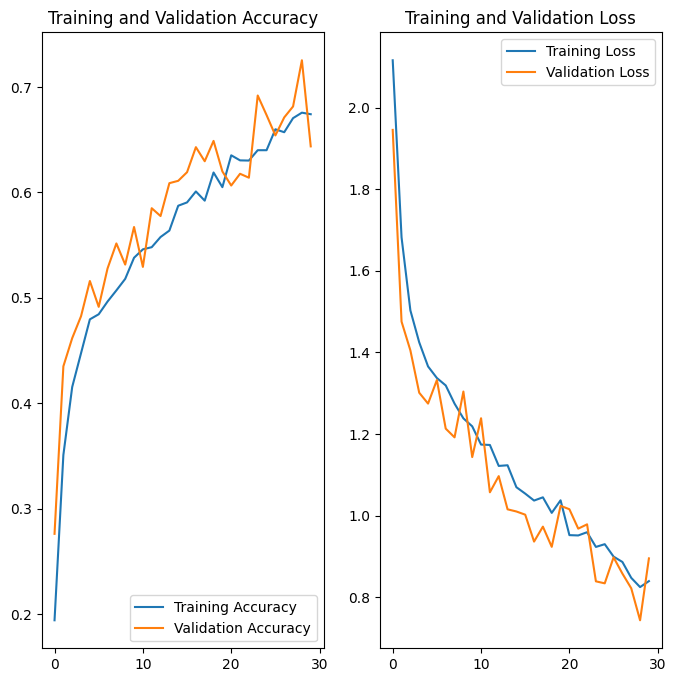

In [130]:
acc = history30.history['accuracy']
val_acc = history30.history['val_accuracy']

loss = history30.history['loss']
val_loss = history30.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [131]:
epochs = 20
## Your code goes here, use 30 epochs.
history20 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)# your model fit code

Epoch 1/20
169/169 [==============================] - 39s 216ms/step - loss: 0.8550 - accuracy: 0.6723 - val_loss: 0.8544 - val_accuracy: 0.6808
Epoch 2/20
169/169 [==============================] - 39s 226ms/step - loss: 0.8312 - accuracy: 0.6747 - val_loss: 0.7636 - val_accuracy: 0.7186
Epoch 3/20
169/169 [==============================] - 39s 227ms/step - loss: 0.7930 - accuracy: 0.6901 - val_loss: 0.9963 - val_accuracy: 0.6251
Epoch 4/20
169/169 [==============================] - 39s 226ms/step - loss: 0.7979 - accuracy: 0.6895 - val_loss: 0.7632 - val_accuracy: 0.7053
Epoch 5/20
169/169 [==============================] - 35s 199ms/step - loss: 0.8044 - accuracy: 0.6897 - val_loss: 0.8319 - val_accuracy: 0.6837
Epoch 6/20
169/169 [==============================] - 36s 208ms/step - loss: 0.7856 - accuracy: 0.6923 - val_loss: 0.7164 - val_accuracy: 0.7283
Epoch 7/20
169/169 [==============================] - 34s 198ms/step - loss: 0.7611 - accuracy: 0.7016 - val_loss: 0.7236 - val_ac

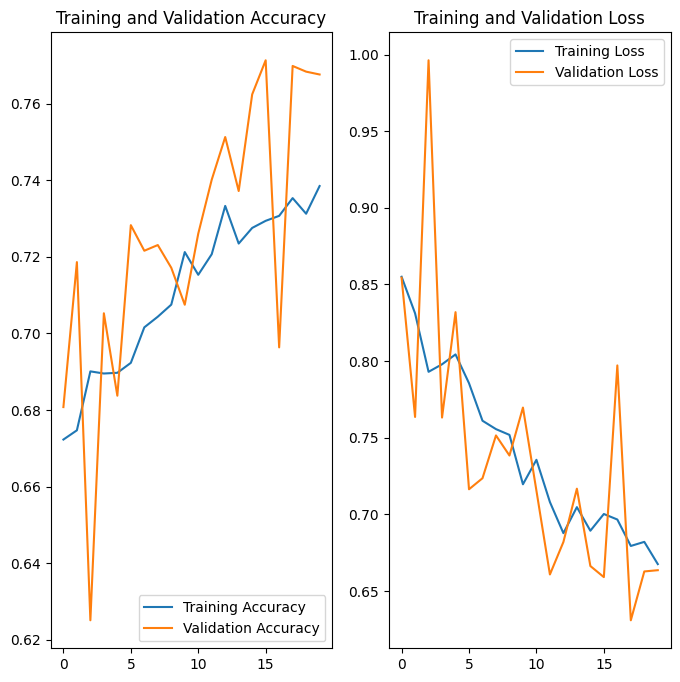

In [132]:
acc = history20.history['accuracy']
val_acc = history20.history['val_accuracy']

loss = history20.history['loss']
val_loss = history20.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()